### Problem Definition :

The Boolean satisfiability problem is a problem wherein we need to determine if a given boolean expression is satisfiable, i.e. if given a boolean formula,  can we change the variables by TRUE or FALSE so that formula evaluates to TRUE. 
The boolean expression or clause is basically a combination of variables and operators enclosed within parentheses. The operators used are AND ( denoted by ∧ ),  OR ( denoted by ∨ ), and NOT ( denoted by ¬ ) . 
This is in general a constraint satisfaction problem. Below, we show how such constraint satisfaction problems with a single solution can be solved using Grover’s algorithm by changing its oracle component.



![alt text](SAT_images/SAT.jpg "Title")

### Circuit Diagram :


<h4><center><i>Single Solution Satisfiability Problem</i></center></h4>
<center><img src="SAT_images/single_oracle.jpg" alt="drawing" width="500"/></center>

<center><img src="SAT_images/single_grover.jpeg" alt="drawing" width="500"/></center>

## Code

#### Importing Libraries

In [1]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
from braket.devices import LocalSimulator
import numpy as np

### Defining Devices and Problem Constraints

In [2]:
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
# device = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')
device = LocalSimulator()
s3_folder = (f"amazon-braket-1c440ad1b4a7","Simulator")


In [3]:
# Problem Dictionary. 1 indicates clause the variable is negated

problem = [
    {
        'A':0,
        'C':1,
    },
    
    {
        'A':0,
        'B':1,
        'D':1,
    },
]

### Implementing the Oracle Component

In [4]:
oracle_1 = Circuit()

# For Constraint 1: (A U ~C)

oracle_1.x([0])
oracle_1.ccnot(0,2,4)
oracle_1.x([0])
    
# For Constraint 2: (A U ~B U ~D)

oracle_1.x([0])
oracle_1.ccnot(0,1,5)
oracle_1.ccnot(3,5,6)

oracle_1.x([0])


oracle_1.ccnot(4,6,7)
oracle_1.cnot(7,8)

oracle_1.ccnot(4,6,7)

oracle_1.x([0])
oracle_1.ccnot(3,5,6)
oracle_1.ccnot(0,1,5)
oracle_1.x([0])

oracle_1.x([0])
oracle_1.ccnot(0,2,4)
oracle_1.x([0])

oracle=oracle_1
print(oracle_1)

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|
                                         
q0 : -X-C-X-X-C-X-X-------C--X--X--C--X--
        |     |           |        |     
q1 : ---|-----C-----------C--------|-----
        |     |           |        |     
q2 : ---C-----|-----------|--------C-----
        |     |           |        |     
q3 : ---|-----|-C-------C-|--------|-----
        |     | |       | |        |     
q4 : ---X-----|-|-C---C-|-|--------X-----
              | | |   | | |              
q5 : ---------X-C-|---|-C-X--------------
                | |   | |                
q6 : -----------X-C---C-X----------------
                  |   |                  
q7 : -------------X-C-X------------------
                    |                    
q8 : ---------------X--------------------

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|


### Implementing The Amplifier Componment

In [5]:
temp=[]
for i in range(16):
    
    temp.append([])
    for j in range(16):
        if(i==j):
            if(i==15):
                temp[i].append(-1.0)
            else:
                temp[i].append(1.0)
        else:
            temp[i].append(0.0)

custom_gate = np.array(temp)

amplify = Circuit()

amplify.h([0,1,2,3])
amplify.x([0,1,2,3]).unitary(matrix=custom_gate, targets=[0,1,2,3]).x([0,1,2,3])
amplify.h([0,1,2,3])

print(amplify)

T  : |0|1|2|3|4|
                
q0 : -H-X-U-X-H-
          |     
q1 : -H-X-U-X-H-
          |     
q2 : -H-X-U-X-H-
          |     
q3 : -H-X-U-X-H-

T  : |0|1|2|3|4|


### Combining Components For the Grover Algorithm

In [10]:
# Satisfiablity problem solver

sat = Circuit()
sat.x([8]).h([0,1,2,3,8])
for i in range(2):
    sat.add(oracle)
    sat.add(amplify)
print(sat)


T  : |0|1|2|3|4|5|6|7|8|9|10|11 |12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31 |32|33|34|35|36|37|38|39|40|
                                                                                                                         
q0 : -H-X-C-X-X-C-X-X--------C---X--X--C--X--H--X--U--X--H--X--C--X--X--C--X--X-----------C---X--X--C--X--H--X--U--X--H--
          |     |            |         |           |           |        |                 |         |           |        
q1 : -H---|-----C------------C---H--X--|-----------U--X--H-----|--------C-----------------C---H--X--|-----------U--X--H--
          |     |            |         |           |           |        |                 |         |           |        
q2 : -H---C-----|------------|---------C--H--X-----U--X--H-----C--------|-----------------|---------C--H--X-----U--X--H--
          |     |            |         |           |           |        |                 |         |           |        
q3 : -H---|-----|-C-----

In [11]:
counts = device.run(sat, shots = 1000).result().measurement_counts
print(counts)

Counter({'011100001': 498, '011100000': 434, '001100000': 5, '101000000': 5, '111000000': 5, '101100000': 4, '111100000': 4, '111100001': 4, '101000001': 4, '000100001': 3, '110100001': 3, '010100000': 3, '000000001': 3, '100000000': 2, '111000001': 2, '000100000': 2, '011000000': 2, '001100001': 2, '010100001': 2, '001000000': 2, '100100000': 2, '101100001': 2, '011000001': 2, '001000001': 1, '110100000': 1, '110000000': 1, '010000000': 1, '100100001': 1})


In [12]:
solutions=[]
total_times=[]

for key, value in counts.items():
    if(key[:4] not in solutions):
        solutions.append(key[:4])
        total_times.append(0)
    total_times[solutions.index(key[:4])] += value

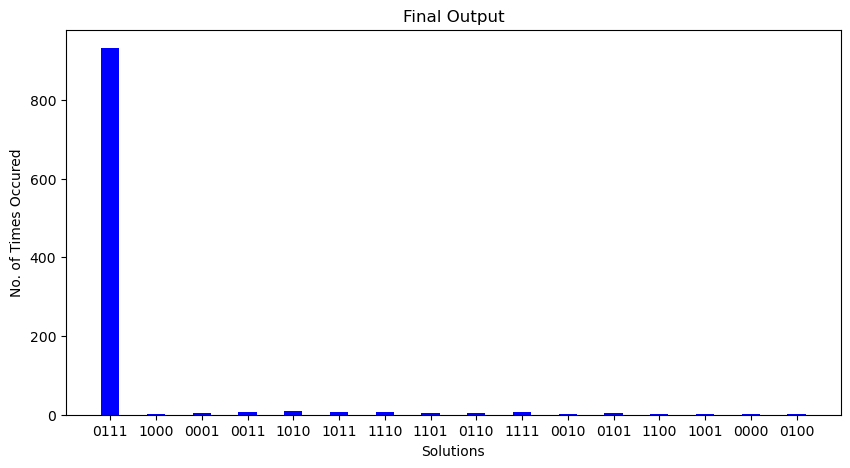

In [13]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(solutions, total_times, color ='blue',
        width = 0.4)
 
plt.xlabel("Solutions")
plt.ylabel("No. of Times Occured")
plt.title("Final Output")
plt.show()